In [2]:
import torch 
import numpy 
dataset_name='ogbl-ddi'
import matplotlib
import matplotlib.pyplot as plt
from ogb.linkproppred import PygLinkPropPredDataset



dataset=PygLinkPropPredDataset(name=dataset_name)




Resources used for inspiration on code:
graph exploration from :
https://medium.com/mlearning-ai/ultimate-guide-to-graph-neural-networks-1-cora-dataset-37338c04fe6f

# Exploring our data

In [3]:
data=dataset[0]
print(f'the {dataset_name} has {len(dataset)} graph')
print(f'number of nodes:{data.num_nodes}')
print(f'number of edges {data.num_edges}')
print(f'number of features {data.num_node_features}')
print(f'is data-graph directed? :{data.is_directed()}')
print(f'data has self-loops? : {data.has_self_loops()}')
print(f'data has isolated nodes? : {data.has_isolated_nodes()}')
print('the graph has average node degree of {:.2f}'.format(data.num_edges/data.num_nodes))

the ogbl-ddi has 1 graph
number of nodes:4267
number of edges 2135822
number of features 0
is data-graph directed? :False
data has self-loops? : False
data has isolated nodes? : False
the graph has average node degree of 500.54


Data edges are given as two arrays 
array[0][i] holds the edge to array [1][i]
we look only on one array and infer the second
 

Helper functions

nx gets edges a stules


In [4]:
#returns a tensor with the indices of neighbors of the node index
def get_neighbors(edge_index,node_index):
    edge_index=edge_index
    return edge_index[:,numpy.where(edge_index[0]==node_index)[0]][1]

import networkx as nx
def visualize_nx(edges_list):
    unique_list=numpy.unique(edges_list)
    print(f'the graph has {unique_list.shape} nodes')
    myGraph=nx.Graph()
    myGraph.add_nodes_from(unique_list)
    
    myGraph.add_edges_from(list(zip(edges_list[0],edges_list[1])))
    plt.figure()
    nx.draw_networkx(myGraph,with_labels=True)

    plt.show()




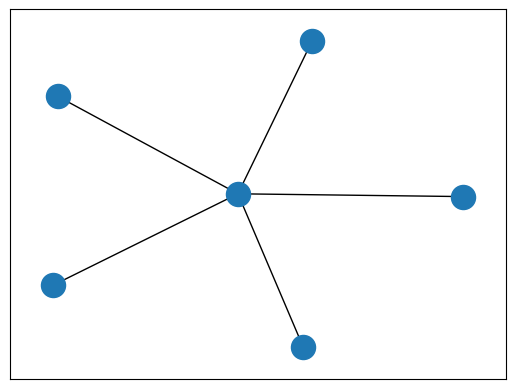

In [5]:
edges2d_t=data.edge_index
node_example_t=edges2d_t[:,numpy.where(edges2d_t[0]==4)[0]]
node_example_n=node_example_t.numpy()[:,:5]
myGraph=nx.Graph()
myGraph.add_nodes_from(numpy.unique(node_example_n))
myGraph.add_edges_from(list(zip(node_example_n[0],node_example_n[1])))



nx.draw_networkx(myGraph,with_labels=False)

In [6]:

node_example_t=edges2d_t[:,numpy.where(edges2d_t[0]==4)[0]].numpy()
node_example_t=node_example_t[:,:5]
node_example_t


array([[   4,    4,    4,    4,    4],
       [ 225, 1182,  738, 2760,  755]], dtype=int64)

In [7]:
%%script echo skipping
myGraph=nx.Graph()
myGraph.add_nodes_from(data.edge_index[0])
myGraph.add_edges_from(list(zip(data.edge_index[0],data.edge_index[1])))

Couldn't find program: 'echo'


In [8]:
import pandas 
def draw_degree_histogram(data):
    myGraph=nx.to_networkx_graph(list(zip(data[0].numpy(),data[1].numpy())))
    degrees=[val for (node,val) in myGraph.degree()]
    
    plt.hist(degrees,bins=range(0,max(degrees)+1))
    ax=plt.gca()
    plt.xlabel("# of interactions per drug (degree)")
    ax.set_ylim([0,30])
    plt.show()
    print(pandas.DataFrame(degrees).describe().transpose().round(3))



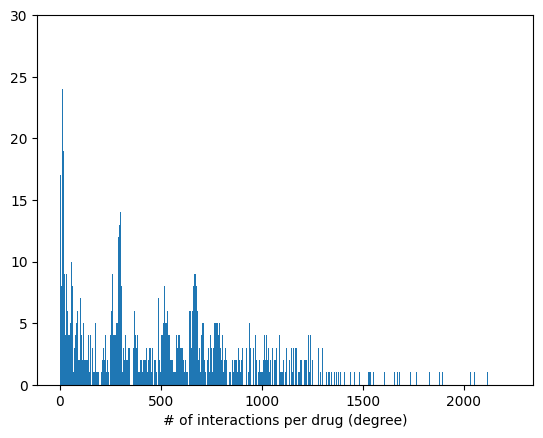

    count     mean      std  min    25%    50%    75%     max
0  4267.0  500.544  420.527  1.0  109.5  446.0  770.0  2234.0


In [9]:
draw_degree_histogram(data.edge_index)

In [10]:
from pylab import rcParams
def draw_most_important(data):
    myGraph=nx.to_networkx_graph(list(zip(data[0].numpy(),data[1].numpy())))
    
    color_lookup={node:degree for node,degree in sorted(myGraph.degree())}
    print(color_lookup)

In [11]:
myGraph=nx.to_networkx_graph(list(zip(data.edge_index[0].numpy(),data.edge_index[1].numpy())))
node_degree_sequence=numpy.array(object= sorted({(n,d) for (n,d) in myGraph.degree()},reverse=True,key=lambda x:x[1]))
node_degree_sequence[:10]

array([[ 807, 2234],
       [ 406, 2219],
       [1037, 2118],
       [ 299, 2091],
       [ 260, 2091],
       [ 485, 2054],
       [1029, 2035],
       [ 431, 2034],
       [ 390, 2026],
       [ 808, 1973]], dtype=int64)

In [12]:
low,high=node_degree_sequence[:,1].min(),node_degree_sequence[:,1].max()
print(f'low degree:{low}, high degree:{high}')

low degree:1, high degree:2234


node 5 has degree 816


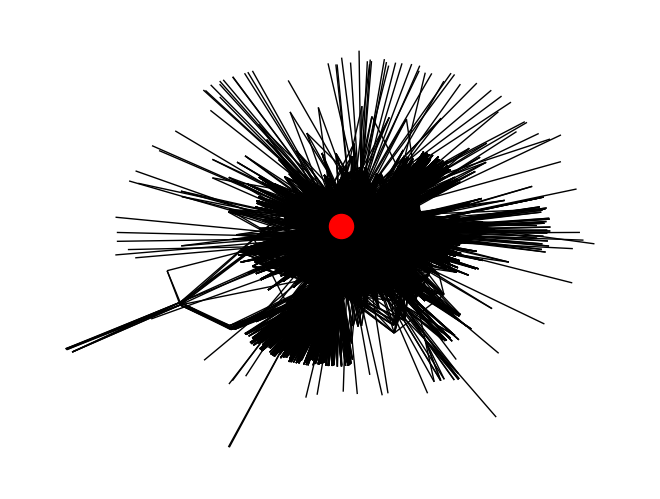

In [15]:
node1=5
degreenode1=myGraph.degree(node1)
print(f'node {node1} has degree {degreenode1}')

nx.draw(
    G=myGraph,
    nodelist=[node1],
    node_color='red',
    with_labels=False,
)
plt.show()

In [24]:
pos=nx.spring_layout(myGraph)
cent=nx.degree_centrality(myGraph)
node_size=list(map(lambda x:x*50,cent.values()))

threshold:0.45405532114392877


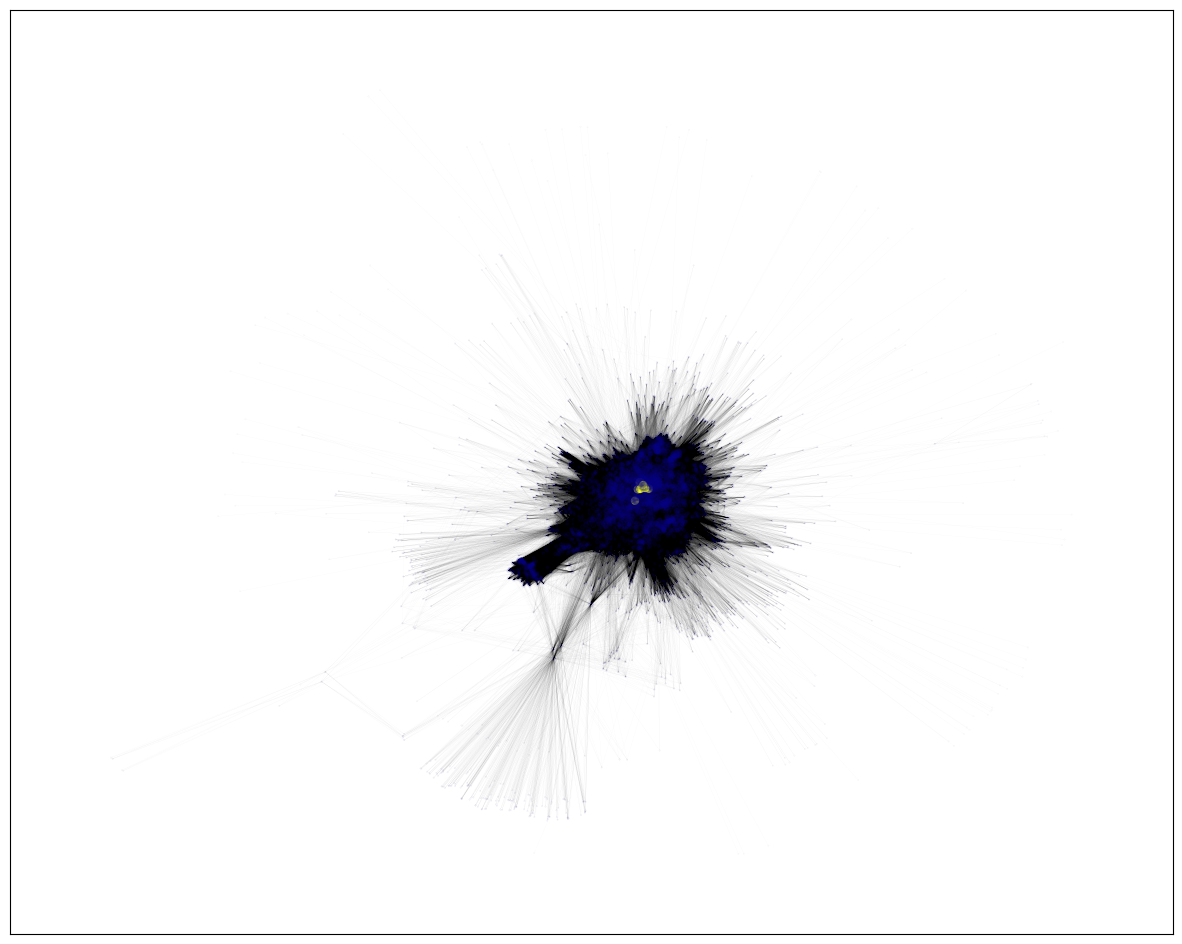

In [25]:
cent_array=numpy.array(list(cent.values()))
threshold=sorted(cent_array,reverse=True)[10]
print(f'threshold:{threshold}')
cent_bin=numpy.where(cent_array>threshold,1,0.1)
plt.figure(figsize=(15,12))
nodes=nx.draw_networkx_nodes(
    G=myGraph,
    pos=pos,
    node_size=node_size,
    cmap=plt.cm.plasma,
    nodelist=list(cent.keys()),
    alpha=cent_bin,
    node_color=cent_bin

)
edges=nx.draw_networkx_edges(
    G=myGraph,
    pos=pos,
    width=0.03, alpha=0.2
)